# **Part 1: Text Processing and Exploratory Data Analysis**


Authors: <font color="blue">Lida Calsamiglia, Patricia Castelijns, Francesca Mees</font>

NIAs:<font color="blue"> 231319, 229651, 230849<font>

Date: <font color="blue">21/10/2023</font>

In [93]:
# If running in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load Python packages
Let's first import all the needed packages

In [94]:
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
from nltk.sentiment import SentimentIntensityAnalyzer
from datetime import datetime

#### Load data into memory
The data ids is stored in the CSV file, and JSON file it contains a set of tweets related to the Russo- Ukrainian War. In the CSV file each tweet has document id and id separated by "\t" character. In the JSON file we loaded 176 variable such as created_at, id, id_str...

In [95]:
df_csv = pd.read_csv('/content/drive/Shareddrives/IRWA/Rus_Ukr_war_data_ids.csv',sep='\t', header=None)
df_csv.columns = ['doc_id','id']
df_csv.head()

doc_id                   id
0  doc_1  1575918221013979136
1  doc_2  1575918081461080065
2  doc_3  1575917992390823936
3  doc_4  1575917907774967809
4  doc_5  1575917878410301441

In [96]:
# Load JSON data from a file

data = []
with open('/content/drive/Shareddrives/IRWA/Rus_Ukr_war_data.json', 'r') as file:
    for line in file:
        try:
            # Parse each line as a JSON object
            json_data = json.loads(line)
            data.append(json_data)
        except json.JSONDecodeError:
            print(f"Invalid JSON: {line}")


# Convert JSON data to a pandas DataFrame
json_df = pd.json_normalize(data)


In [97]:
json_df.head()

created_at                   id               id_str  \
0  Fri Sep 30 18:39:17 +0000 2022  1575918221013979136  1575918221013979136   
1  Fri Sep 30 18:38:44 +0000 2022  1575918081461080065  1575918081461080065   
2  Fri Sep 30 18:38:23 +0000 2022  1575917992390823936  1575917992390823936   
3  Fri Sep 30 18:38:03 +0000 2022  1575917907774967809  1575917907774967809   
4  Fri Sep 30 18:37:56 +0000 2022  1575917878410301441  1575917878410301441   

                                                                                                                                                                                                                                                                                            full_text  \
0                                                                                                                                             @MelSimmonsFCDO Wrong. Dictator Putin's Fascist Russia intends to conquer as much Ukrainian Land as possible.\n#RussiainvadesUkraine\n#UkraineRussiaWar   
1  🇺🇦❤️ The Armed Forces liberated the village of #Drobysheve of the #Lymansk urban territorial community in #Donetsk region.#UkraineRussiaWar\n#UkraineWar #Ukraine️ #UkraineWillWin #UkrainianArmy #ukrainecounteroffensive #UkraineWarNews #SlavaUkraïni #StandWithUkraine https://t.co/ifg0RXDMBQ   
2                                                                                                                                                             ALERT 🚨Poland preps anti-radiation tablets over nuclear threat\n\n#NATO #Putin #Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar   
3                                                                                                                                             I’m still waiting for my google map 🗺️ to update Russia 🇷🇺 new annexed territory but it’s taking a bit longer than I thought 🤔 #Putin #UkraineRussiaWar   
4                                                                                                                                       @EmmanuelMacron probably you're right or you have to say it, anyway it's game over and #European citizens are tired to pay for this endless #UkraineRussiaWar   

   truncated display_text_range  \
0      False          [16, 149]   
1      False           [0, 265]   
2      False           [0, 133]   
3      False           [0, 151]   
4      False          [16, 157]   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
3    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

   in_reply_to_status_id in_reply_to_status_id_str  in_reply_to_user_id  ...  \
0           1.575767e+18       1575766913334251520         8.270929e+07  ...   
1                    NaN                      None                  NaN  ...   
2                    NaN                      None                  NaN  ...   
3                    NaN                      None                  NaN  ...   
4           1.575906e+18       1575906157088370688         1.976143e+09  ...   

  quoted_status.place.place_type quoted_status.place.name  \
0                            NaN                      NaN   
1                            NaN                      NaN   
2                            NaN                      NaN   
3                            NaN                      NaN   
4                            NaN                      NaN   

  quoted_status.place.full_name quoted_status.place.country_code  \
0                           NaN                              NaN   
1                      

In [98]:
print("Total number of tweets in the corpus (which is a set of tweets related to the Russo- Ukrainian War):", len(json_df))

Total number of tweets in the corpus (which is a set of tweets related to the Russo- Ukrainian War): 4000


### Pre-process the tweets

We define a function that takes a tweet and performs the following operations:


*   Transform all text to lowercase
*   Tokenize the text to get a list of terms
*   Remove stop words
*   Removing punctuation marks
*   Stem terms
*   Removing URLs, both "http" and "https" ones.

In [99]:
nltk.download('stopwords')
def preprocess_tweet(tweet, stemming, split):
    """
    Preprocess the tweet removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    tweet to be preprocessed

    Returns:
    tweet - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    tweet = re.sub(r'https\S+','',tweet) # Removing URLs, both "http" and "https" ones.
    tweet = re.sub(r'http\S+','',tweet) # Removing URLs, both "http" and "https" ones.
    tweet = tweet.lower() ## Transform in lowercase
    tweet = re.sub(r'[^\w\s@#]', '', tweet) # Remove punctuation marks except @,#
    tweet = re.sub(r'#\S+', '', tweet) # Remove hashtags

    if split:
      tweet = tweet.split() ## Tokenize the text to get a list of terms
      tweet = [word for word in tweet if word not in stop_words]  # Eliminate the stopwords
    if stemming:
      tweet = [stemmer.stem(word) for word in tweet] # Perform stemming

    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
# Create new column with the text of the tweets preprocessed
json_df['preprocessed_text'] = json_df['full_text'].apply(lambda x: preprocess_tweet(x,stemming=True, split=True))

In [101]:
# Add columns of interest: hashtags and tweet url
json_df['tweet_url'] = np.nan * len(json_df)
for tweet in range(len(json_df)):
    media_tweet = json_df.at[tweet, 'entities.media']

    if pd.notna(media_tweet) and len(media_tweet) > 0:
        json_df.at[tweet, 'tweet_url'] = media_tweet[0]['url']
    else:
        json_df.at[tweet, 'tweet_url'] = 'no url'

hashtags = []
for tweet in range(len(json_df)):
  hashtags.append([item['text'] for item in json_df['entities.hashtags'][tweet]])

json_df['hashtags'] = hashtags

### Define dataframes

In [102]:
final_df = json_df[['created_at','id', 'preprocessed_text', 'favorite_count', 'retweet_count','hashtags',  'tweet_url']]
analytics_df = json_df[['created_at','id', 'full_text', 'preprocessed_text', 'favorite_count', 'retweet_count','hashtags']].copy()

In [103]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   created_at         4000 non-null   object
 1   id                 4000 non-null   int64 
 2   preprocessed_text  4000 non-null   object
 3   favorite_count     4000 non-null   int64 
 4   retweet_count      4000 non-null   int64 
 5   hashtags           4000 non-null   object
 6   tweet_url          4000 non-null   object
dtypes: int64(3), object(4)
memory usage: 218.9+ KB


In [ ]:
pd.set_option('max_colwidth', None)
final_df.head(3)

created_at                   id  \
0  Fri Sep 30 18:39:17 +0000 2022  1575918221013979136   
1  Fri Sep 30 18:38:44 +0000 2022  1575918081461080065   
2  Fri Sep 30 18:38:23 +0000 2022  1575917992390823936   

                                                                                           preprocessed_text  \
0  [@melsimmonsfcdo, wrong, dictat, putin, fascist, russia, intend, conquer, much, ukrainian, land, possibl]   
1                                               [arm, forc, liber, villag, urban, territori, commun, region]   
2                                                   [alert, poland, prep, antiradi, tablet, nuclear, threat]   

   favorite_count  retweet_count  \
0               0              0   
1               0              0   
2               0              0   

                                                                                                                                                                         hashtags  \
0                                                                                                                                        [RussiainvadesUkraine, UkraineRussiaWar]   
1  [Drobysheve, Lymansk, Donetsk, UkraineRussiaWar, UkraineWar, Ukraine️, UkraineWillWin, UkrainianArmy, ukrainecounteroffensive, UkraineWarNews, SlavaUkraïni, StandWithUkraine]   
2                                                                                                          [NATO, Putin, Russia, RussiaInvadedUkraine, Ukraine, UkraineRussiaWar]   

                 tweet_url  
0                      NaN  
1  https://t.co/ifg0RXDMBQ  
2                      NaN

## Exploratory Data Analysis

### Word Counting Distribution

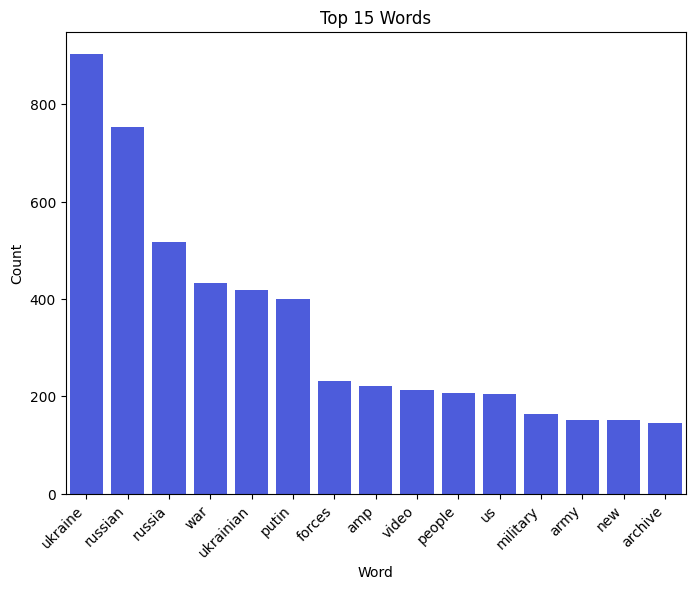

In [ ]:
# List containing all the words of all tweets
all_words = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x,stemming=False, split=True)).explode().tolist()

# Create df with each word and its corresponding number of occurrences
counter_words = Counter(all_words)
counter_words_df = pd.DataFrame(list(counter_words.items()),columns=['word','count']).sort_values(by='count', ascending=False)

# Plot 30 most frequent words
plt.figure(figsize=(8, 6))
sns.barplot(x='word', y = 'count', data=counter_words_df.head(15), palette=['#3549F3'])
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 Words')
plt.xticks(rotation=45, ha='right')
plt.show()

###Word Cloud

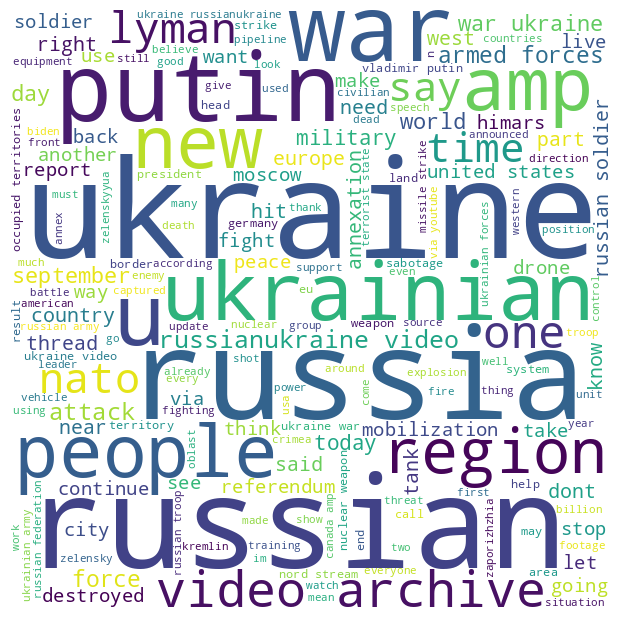

In [86]:
tweets = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x, stemming=False, split=True))

# Initialize string that will contain all the words from all the tweets concatenated together, separated by spaces.
all_words = ''
stopwords = set(STOPWORDS)

for word in tweets:
    all_words += " ".join(word)+" "

wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_words)

# Plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###Average Sentence Length

In [ ]:
def count_words(tweet,stemming=False,split=True):
    """
    Count words in a tweet

    Argument:
    tweet which words we want to count

    Returns:
    number of words in that tweet
    """
    tweet_words = preprocess_tweet(tweet,stemming=False,split=True)
    return len(tweet_words)

In [ ]:
from nltk.corpus import stopwords

analytics_df['word_count'] = analytics_df['full_text'].apply(lambda x: count_words(x,stemming=False, split=True))
average = round(np.mean(analytics_df['word_count']))
print(f"The average sentence length is {average} words")

The average sentence length is 11 words


### Vocabulary size

To measure the vocabulary size we can simply get the number of distinct words across all tweets

In [ ]:
print("The vocabulary size is: ",len(set(all_words)))

The vocabulary size is:  93


### Most popular hashtags

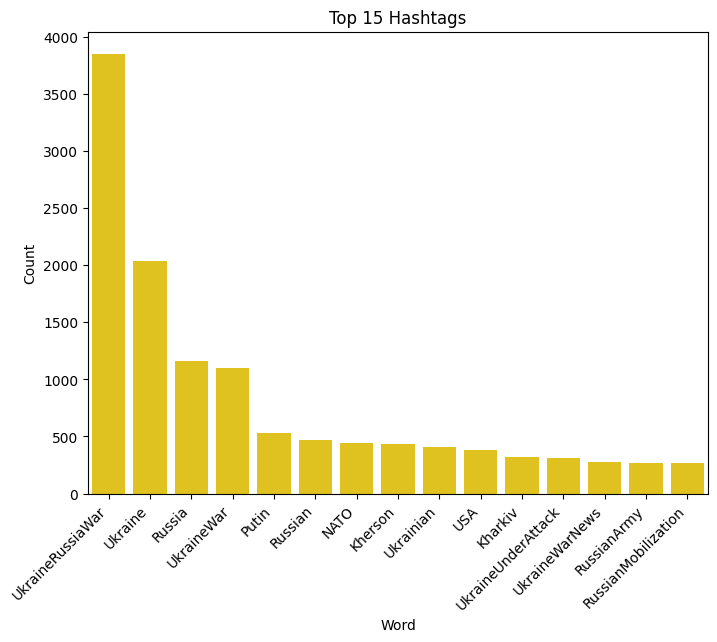

In [ ]:
hashtag_count = Counter(analytics_df['hashtags'].explode().to_list())
counter_hashtag_df = pd.DataFrame(list(hashtag_count.items()),columns=['hashtag','count']).sort_values(by='count', ascending=False)

# Plot top 15 hashtags
plt.figure(figsize=(8, 6))
sns.barplot(x='hashtag', y = 'count', data=counter_hashtag_df.head(15), palette=['gold'])
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 Hashtags')
plt.xticks(rotation=45, ha='right')
plt.show()

### Ranking of tweets most retweeted

In [ ]:
analytics_df['username'] = json_df[['user.screen_name']]

In [ ]:
pd.set_option('max_colwidth', None)
print('TOP 10 MOST RETWEETED TWEETS: ')
display(analytics_df[['full_text','retweet_count']].sort_values(by='retweet_count',ascending=False).head(10))
pd.reset_option('max_colwidth')


TOP 10 MOST RETWEETED TWEETS: 


full_text  \
1219                     🗺️Situation around Lyman - Sep 30 11:00:\n- UA forces liberated Yampil and advancing north\n- RU troops are reportedly abandoning its positions in Drobysheve\n- The only exit route from Lyman is within the firing range of UA forces\n#UkraineRussiaWar https://t.co/jGJUhXcr1y   
2813                                                                 📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.\n#UkraineRussiaWar https://t.co/AmSijyM59c   
3765                                                                                                                 📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.\n#UkraineRussiaWar https://t.co/oYWThs8qNe   
1846  The following countries have urged their citizens to leave 🇷🇺 will update if other governments make similar statements. \n#UkraineRussiaWar #AnnexationofUkraine\n#NAFO \n\nPoland 🇵🇱\nEstonia 🇪🇪\nLatvia 🇱🇻\nItaly 🇮🇹\nUnited States 🇺🇲\nBulgaria 🇧🇬\nRomania 🇷🇴\nTaiwan 🇹🇼\nCanada  🇨🇦\nPortugal 🇵🇹   
1387                                                                                   📽️Russians shelled the outskirts of #Zaporizhzhia and hit a civilian humanitarian convoy heading towards the occupied parts. 23 people were killed, a dozen more wounded.\n#UkraineRussiaWar https://t.co/365j43jy51   
1209                                  The war will not end with the so called annexation referendums which are not genuine expression of the popular will. We are taking a stance to protect our national sovereignty and territorial integrity.\n#Ukraine #UkraineRussiaWar  #NFTs https://t.co/yfZAeV7K8d   
1532                                            Russia may have dropped 11 meters long X-22 missile that weighs more than 900 kg, on Ukrainian/NATO forces in #Dnipro \nRussia to use FAB papa bombs and heavy missiles to end this war \n#NATORussiaWar #UkraineRussiaWar #Kherson https://t.co/NuRQPVMzkJ   
205                                                                                                                                                                                              📽️🇺🇦 Ukrainian forces liberated Drobysheve in #Donetsk Oblast. \n#UkraineRussiaWar https://t.co/7wUCdcA7NZ   
2118                              🗞️Kostyantyn Nemichev, the commander of Kraken Special Unit, recently revelated that Kraken has more than 1500 people and is size of regiment. That makes it currently one of the largest Ukrainian unit formed by volunteers.\n#UkraineRussiaWar https://t.co/vpQcmL92q7   
3801                                                                                                                                                                         📽️Ukrainian paratroopers on BTR-3 during the offensive in #Kharkiv/#Donetsk Oblast.\n#UkraineRussiaWar https://t.co/00LrzsG7QO   

      retweet_count  
1219            646  
2813            338  
3765            283  
1846            251  
1387            247  
1209            236  
1532            184  
205             171  
2118            136  
3801            133

### Sentiment analysis


- consider emoji?
- stemmed vs. unstemmed tokens

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

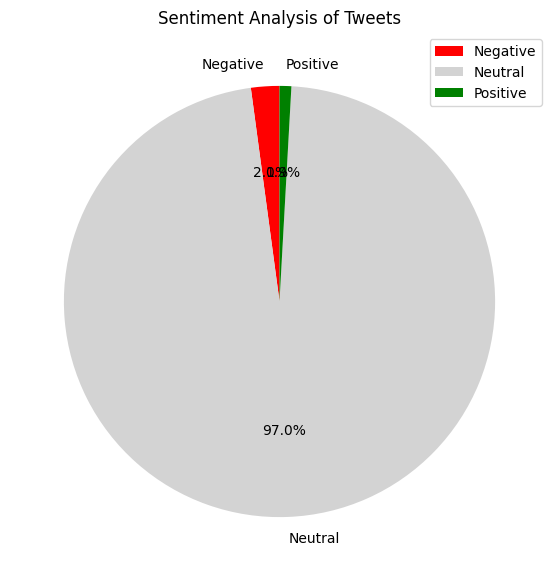

In [ ]:
all_tweets = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x, stemming=False, split=False))

sia = SentimentIntensityAnalyzer()
neg_count = 0
pos_count = 0
neu_count = 0
for tweet in all_tweets:
  sentiment_scores = sia.polarity_scores(tweet)
  max_key = max(sentiment_scores, key=sentiment_scores.get)
  if max_key == 'neg':
    neg_count += 1
  if max_key == 'pos':
    pos_count += 1
  if max_key == 'neu':
    neu_count += 1

labels = ['Negative', 'Neutral', 'Positive']
counts = [neg_count, neu_count, pos_count]

plt.figure(figsize=(7, 7))

plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'lightgray', 'green'])
plt.title('Sentiment Analysis of Tweets')
plt.legend()
plt.show()

###Social Network Analysis

***Top mentioned users/entities***

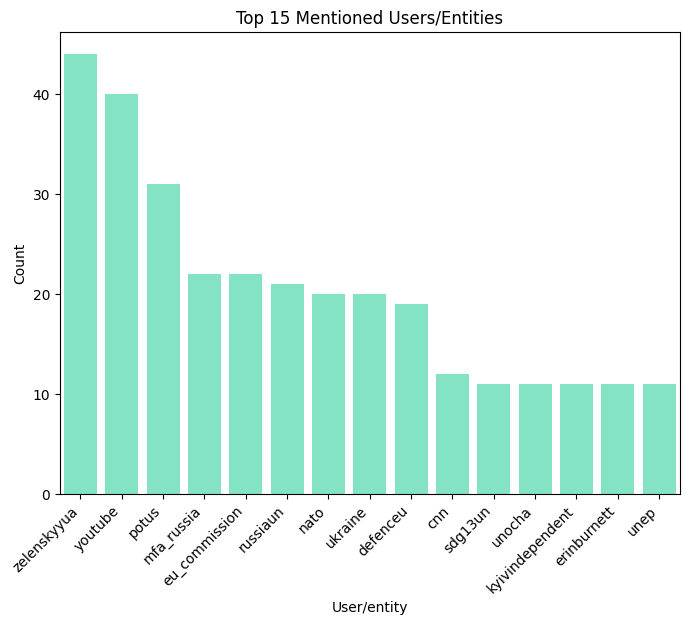

In [ ]:
mentions = []
for tweet in all_tweets:
  mentions.append(re.findall(r'@(\w+)', tweet))
mentions_count = Counter([item for sublist in mentions for item in sublist])
counter_mentions_df = pd.DataFrame(list(mentions_count.items()),columns=['mention','count']).sort_values(by='count', ascending=False)

# Plot top 15 mentioned users
plt.figure(figsize=(8, 6))
sns.barplot(x='mention', y = 'count', data=counter_mentions_df.head(15), palette=['#76F2CB'])
plt.xlabel('User/entity')
plt.ylabel('Count')
plt.title('Top 15 Mentioned Users/Entities')
plt.xticks(rotation=45, ha='right')
plt.show()


***Twitter User Mention Network***

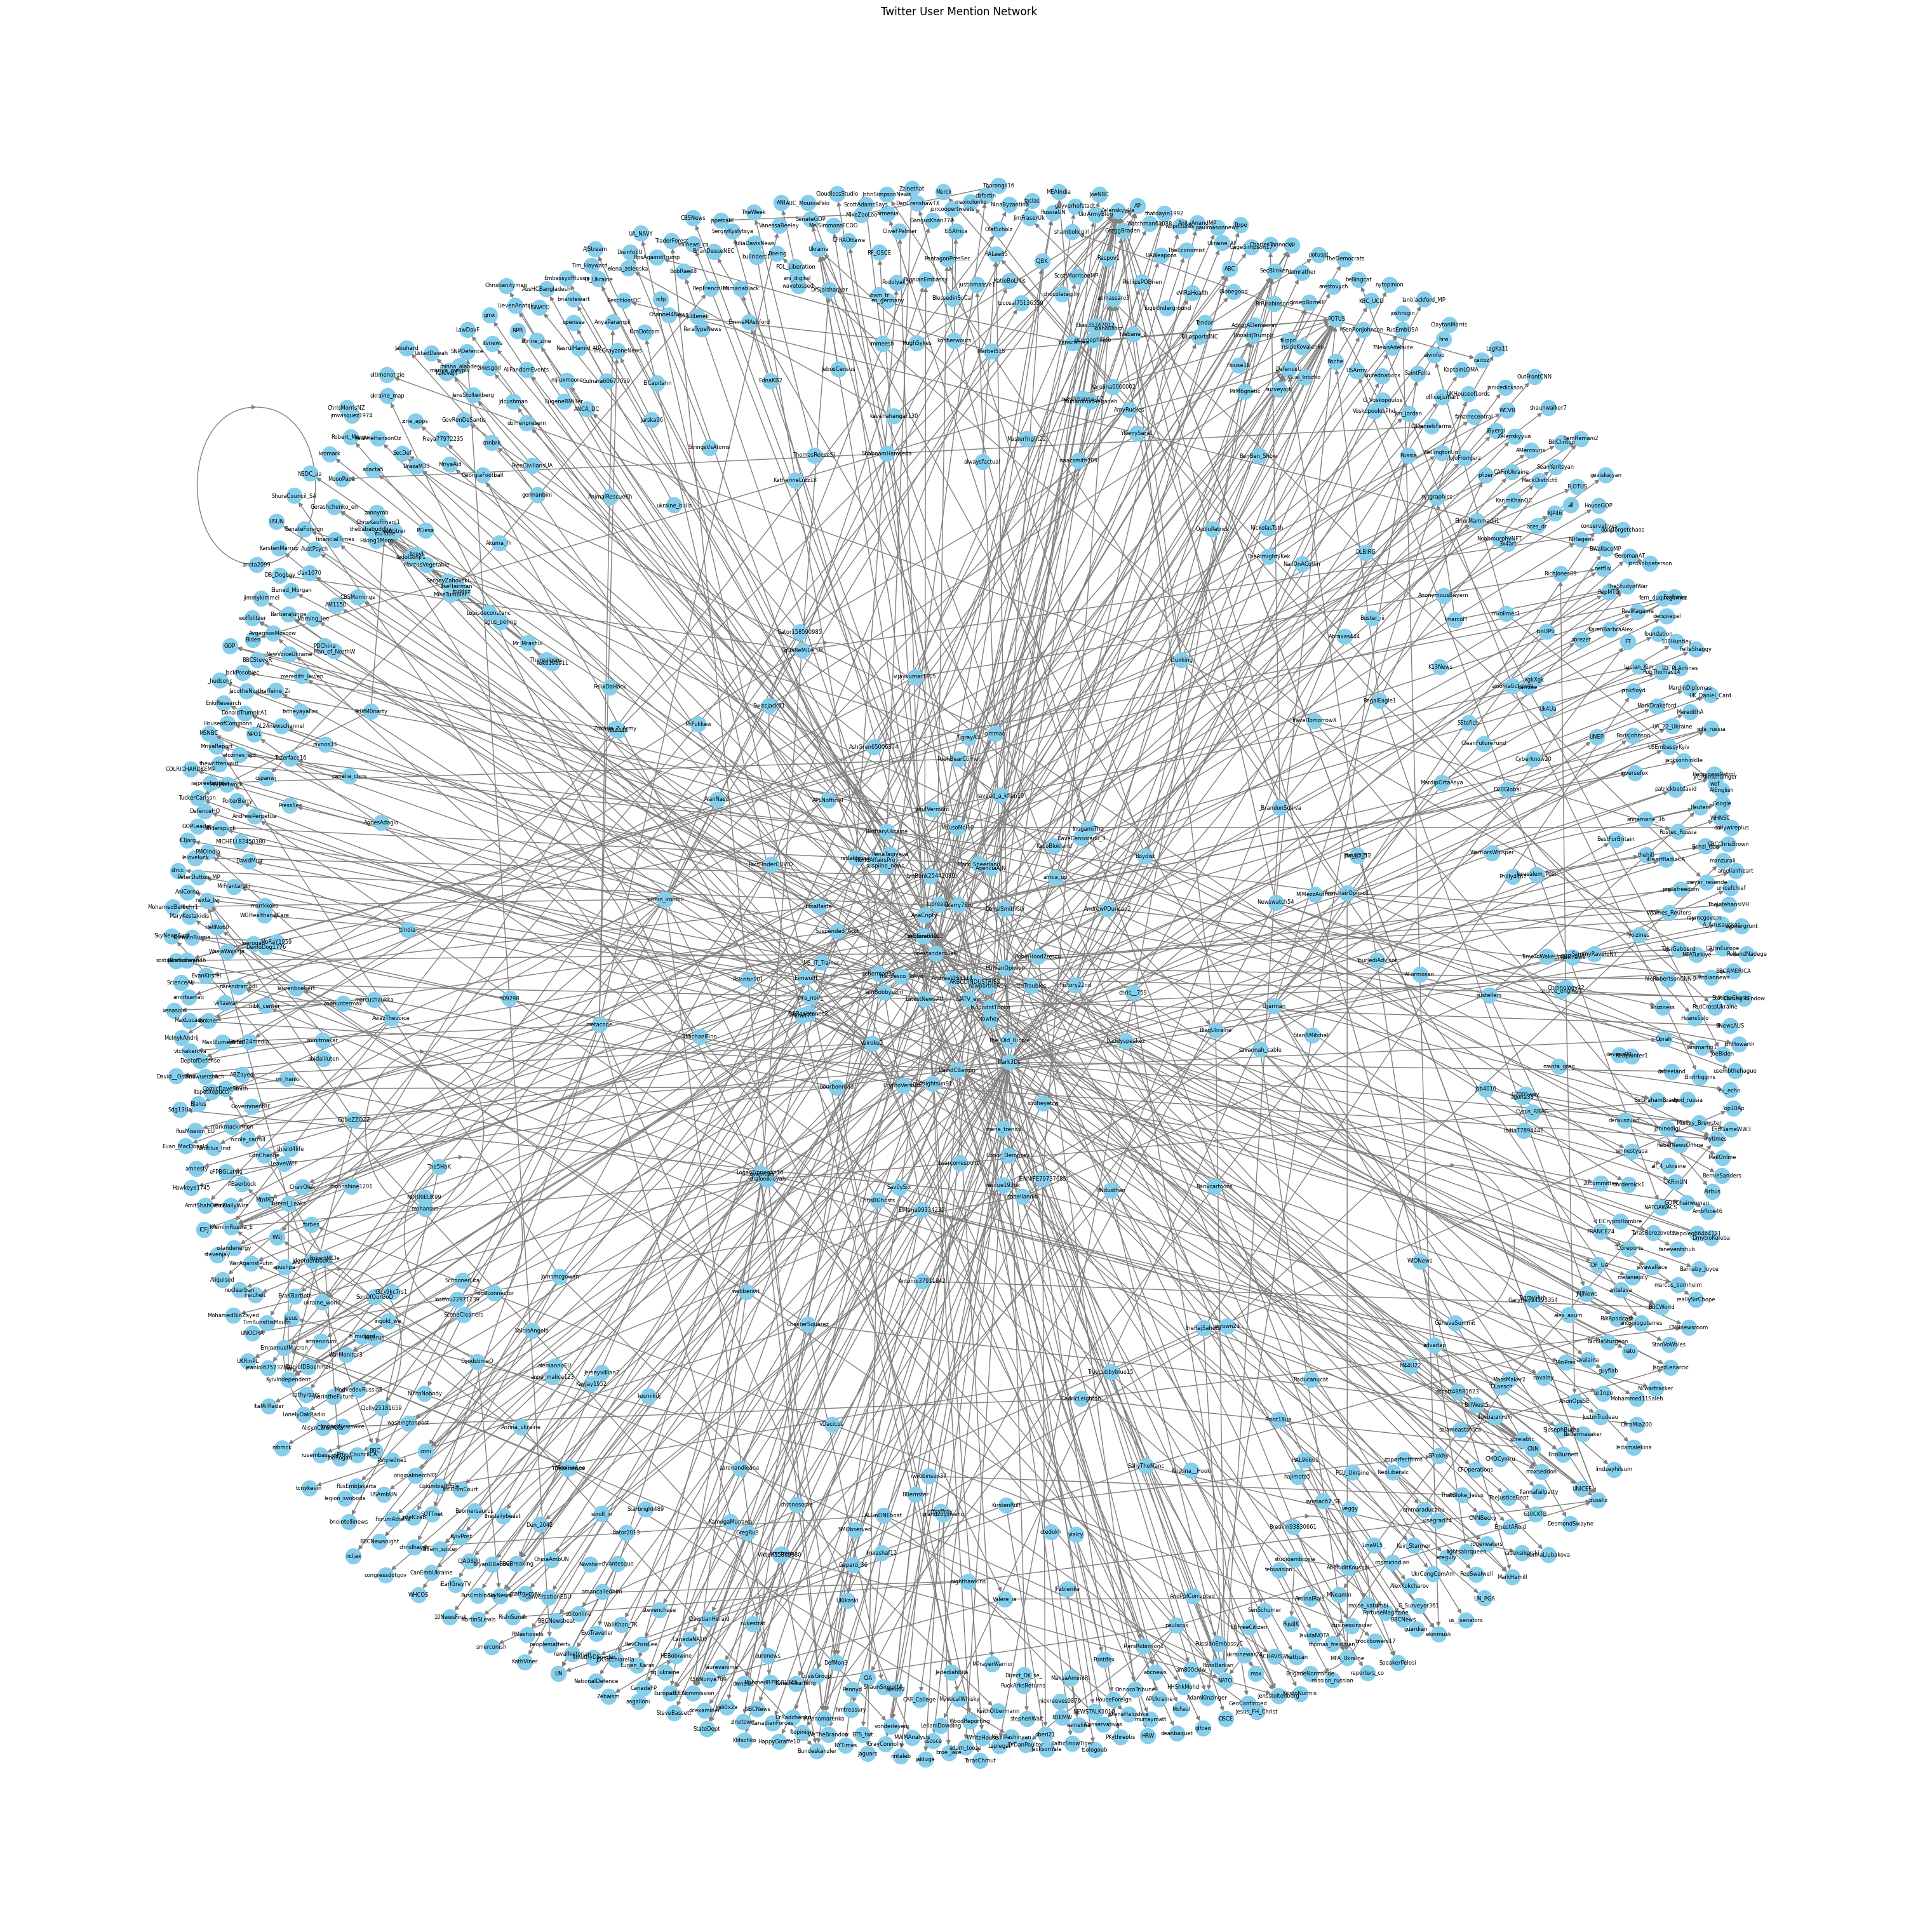

In [ ]:
# Create a directed graph
G = nx.DiGraph()

all_tweets = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x, stemming=False, split=False))

for index, row in analytics_df[['full_text', 'username']].iterrows():
    username = row['username']
    tweet = row['full_text']

    # Extract mentions from the tweet
    mentions = re.findall(r'@(\w+)', tweet)

    # Add edges from the username to mentioned users
    for mentioned_user in mentions:
        G.add_edge(username, mentioned_user)

# Plot the network graph
plt.figure(figsize=(30,30))
nx.draw(G, with_labels=True,font_size=6, node_color='skyblue', edge_color='gray')
plt.title('Twitter User Mention Network')
plt.show()

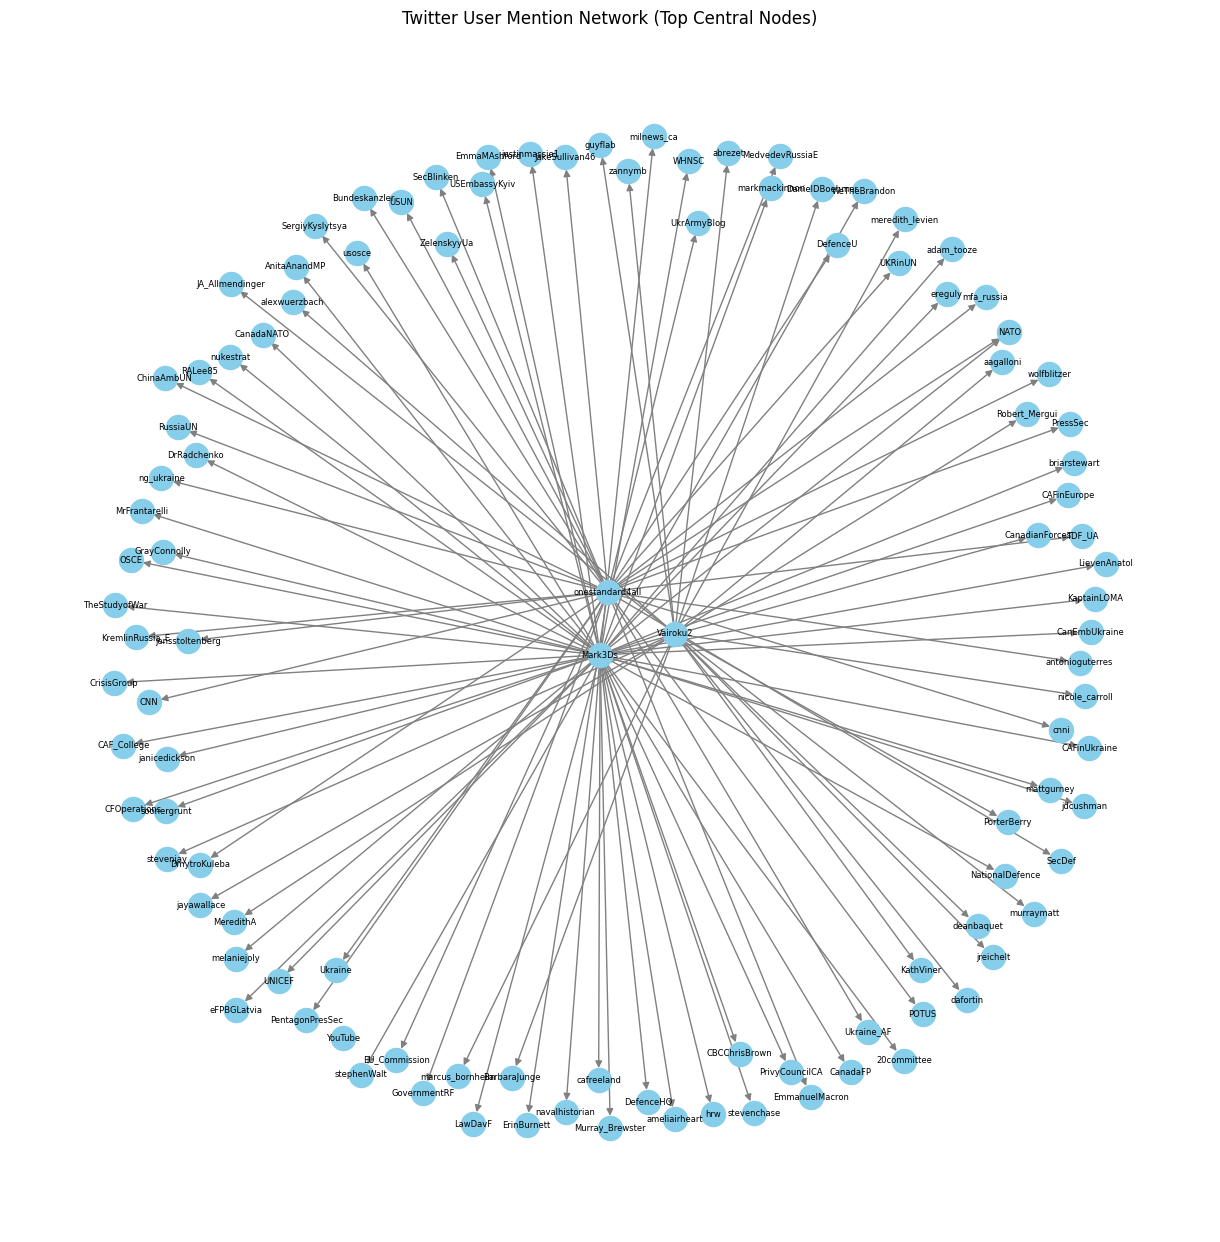

In [77]:

# Create a directed graph
G = nx.DiGraph()

for index, row in analytics_df[['full_text', 'username']].iterrows():
    username = row['username']
    tweet = row['full_text']

    # Extract mentions
    mentions = re.findall(r'@(\w+)', tweet)

    # Add edges from the username to mentioned users
    for mentioned_user in mentions:
        G.add_edge(username, mentioned_user)

# Calculate degree centrality
centrality = nx.degree_centrality(G)

# Identify the top 5 central nodes
top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:5]

# Create a subgraph with only the top nodes and their neighbors
subgraph = G.subgraph(top_nodes + [neighbor for node in top_nodes for neighbor in G.neighbors(node)])


# Plot the network graph
plt.figure(figsize=(12, 12))
nx.draw(subgraph, with_labels=True, font_size=6, node_color='skyblue', edge_color='gray', arrowsize=10)
plt.title('Twitter User Mention Network (Top Central Nodes)')
plt.show()


***Most active users***




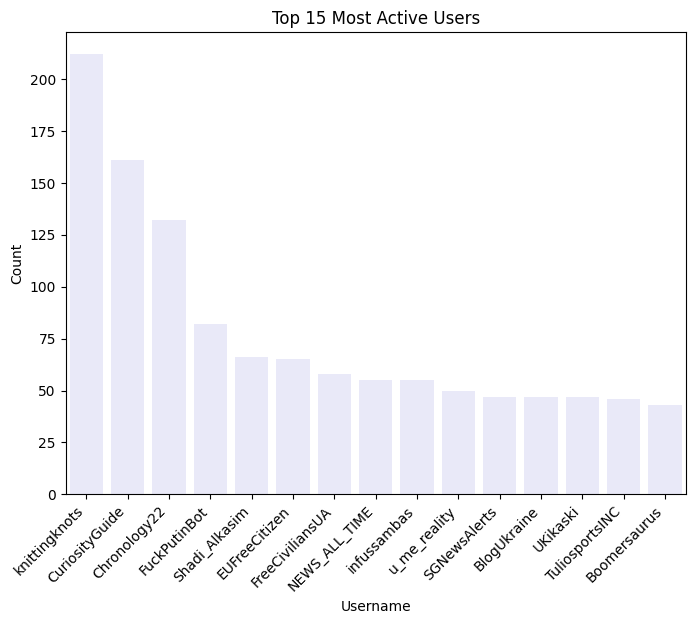

In [ ]:
# Create df with each word and its corresponding number of occurrences
counter_unames = Counter(analytics_df['username'])
counter_unames_df = pd.DataFrame(list(counter_unames.items()),columns=['username','count']).sort_values(by='count', ascending=False)
counter_unames_df

# Plot 15 most active users
plt.figure(figsize=(8, 6))
sns.barplot(x='username', y = 'count', data=counter_unames_df.head(15), palette=['#E6E6FA'])
plt.xlabel('Username')
plt.ylabel('Count')
plt.title('Top 15 Most Active Users')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
top_usernames = counter_unames_df.head(15)['username']
analytics_df.loc[analytics_df['username'].isin(top_usernames)].drop_duplicates(subset='username')[['full_text','username']].head(15)

full_text         username
2    ALERT 🚨Poland preps anti-radiation tablets ove...    NEWS_ALL_TIME
7    #UkraineRussiaWar #Ukraine #Russia\n\n#OSCE co...    EUFreeCitizen
12   🇺🇦🇪🇺\nBerlin is Ukraine\nBrussels is Ukraine\n...  FreeCiviliansUA
17   Russian bombers capable of carrying nukes dete...    Shadi_Alkasim
35   #219dayofwar\n\n🚨An air raid warning has been ...      BlogUkraine
51   Mur fuck lilek innifsek, Putin!\n(Maltese)\n\n...     FuckPutinBot
61   Current air alert map for UA.  Putin is mad th...         UKikaski
98   NATO Chief Says Putin's Recent Actions Are 'Se...    knittingknots
139  Gifts from Poland for Ukraine.\n #Russians #Ru...      infussambas
147  🇺🇦Not Russia\n\n#RussiaIsLosing  #NAFO #Fellas...     Boomersaurus
177  3o/9\n🇷🇺⚡️🇺🇦\nMore scrap metal on the way. Arm...     u_me_reality
231  Putin Wishes a Happy 'Lyman Encirclement Day' ...   TuliosportsINC
333  Correction: It is not a Su-25. It is either a ...     Chronology22
408  Ukraine officially applies for NATO membership...     SGNewsAlerts
746  #Russia #Ukraine #Europe \nWhy The West Hesita...   CuriosityGuide

***Users of the most retweeted and liked tweets***

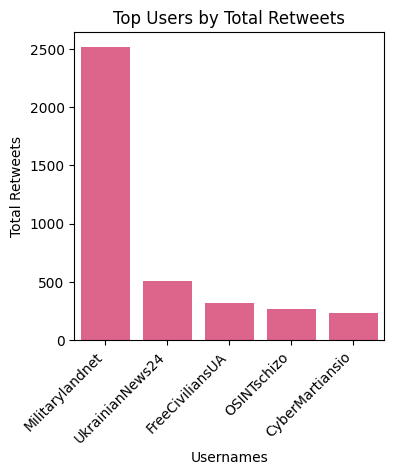

In [ ]:
retweet_counts_by_user = analytics_df.groupby('username')['retweet_count'].sum()

# Get the top usernames with the highest total retweets
top_retweet_users = retweet_counts_by_user.nlargest(5)

# Create the bar plot
plt.figure(figsize=(4, 4))
ax = sns.barplot(x=top_retweet_users.index, y=top_retweet_users.values, color='#F15083')
ax.set(xlabel='Usernames', ylabel='Total Retweets')
plt.title('Top Users by Total Retweets')
plt.xticks(rotation=45, ha='right')

plt.show()

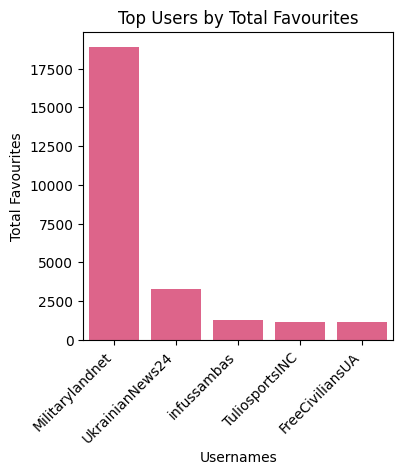

In [ ]:
analytics_df[['full_text','favorite_count']].sort_values(by='favorite_count',ascending=False).head(10)
fav_counts_by_user = analytics_df.groupby('username')['favorite_count'].sum()

# Get the top usernames with the highest total retweets
top_fav_users = fav_counts_by_user.nlargest(5)

# Create the bar plot
plt.figure(figsize=(4, 4))
ax = sns.barplot(x=top_fav_users.index, y=top_fav_users.values, color='#F15083')
ax.set(xlabel='Usernames', ylabel='Total Favourites')
plt.title('Top Users by Total Favourites')
plt.xticks(rotation=45, ha='right')

plt.show()

###Temporal Distribution of Tweets on Russia-Ukraine War

In [ ]:
def get_hour(date):
  d = datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y")
  return d.hour

analytics_df['hour_created'] = analytics_df['created_at'].apply(lambda x: get_hour(x))

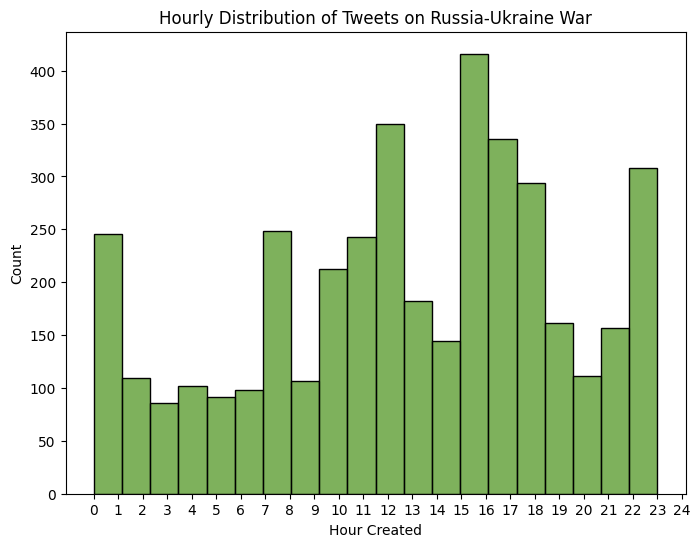

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(analytics_df['hour_created'], bins=20,kde=False, color='#539726')
plt.xticks(range(25))
plt.xlabel('Hour Created')
plt.ylabel('Count')
plt.title('Hourly Distribution of Tweets on Russia-Ukraine War')
plt.show()

### analytics df header and info

In [ ]:
pd.set_option('max_colwidth', None)
analytics_df.head(3)

created_at                   id  \
0  Fri Sep 30 18:39:17 +0000 2022  1575918221013979136   
1  Fri Sep 30 18:38:44 +0000 2022  1575918081461080065   
2  Fri Sep 30 18:38:23 +0000 2022  1575917992390823936   

                                                                                                                                                                                                                                                                                            full_text  \
0                                                                                                                                             @MelSimmonsFCDO Wrong. Dictator Putin's Fascist Russia intends to conquer as much Ukrainian Land as possible.\n#RussiainvadesUkraine\n#UkraineRussiaWar   
1  🇺🇦❤️ The Armed Forces liberated the village of #Drobysheve of the #Lymansk urban territorial community in #Donetsk region.#UkraineRussiaWar\n#UkraineWar #Ukraine️ #UkraineWillWin #UkrainianArmy #ukrainecounteroffensive #UkraineWarNews #SlavaUkraïni #StandWithUkraine https://t.co/ifg0RXDMBQ   
2                                                                                                                                                             ALERT 🚨Poland preps anti-radiation tablets over nuclear threat\n\n#NATO #Putin #Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar   

                                                                                           preprocessed_text  \
0  [@melsimmonsfcdo, wrong, dictat, putin, fascist, russia, intend, conquer, much, ukrainian, land, possibl]   
1                                               [arm, forc, liber, villag, urban, territori, commun, region]   
2                                                   [alert, poland, prep, antiradi, tablet, nuclear, threat]   

   favorite_count  retweet_count  \
0               0              0   
1               0              0   
2               0              0   

                                                                                                                                                                         hashtags  \
0                                                                                                                                        [RussiainvadesUkraine, UkraineRussiaWar]   
1  [Drobysheve, Lymansk, Donetsk, UkraineRussiaWar, UkraineWar, Ukraine️, UkraineWillWin, UkrainianArmy, ukrainecounteroffensive, UkraineWarNews, SlavaUkraïni, StandWithUkraine]   
2                                                                                                          [NATO, Putin, Russia, RussiaInvadedUkraine, Ukraine, UkraineRussiaWar]   

   word_count         username  hour_created  
0          12  LynBank25442089            18  
1           8     Feher_Junior            18  
2           7    NEWS_ALL_TIME            18

In [ ]:
analytics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   created_at         4000 non-null   object
 1   id                 4000 non-null   int64 
 2   full_text          4000 non-null   object
 3   preprocessed_text  4000 non-null   object
 4   favorite_count     4000 non-null   int64 
 5   retweet_count      4000 non-null   int64 
 6   hashtags           4000 non-null   object
 7   word_count         4000 non-null   int64 
 8   username           4000 non-null   object
 9   hour_created       4000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 312.6+ KB
